In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms 

%matplotlib inline 

# 1. Load the data

In [2]:
import csv
from torch.utils.data.dataset import Dataset 

def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive')
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative')
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

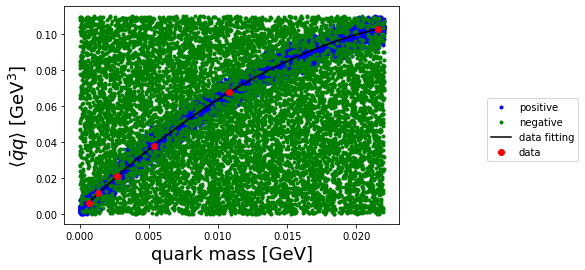

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [6]:
import torch.nn as nn 
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1
def f(phi, pi):
    return pi
def t(a):
    return 0.5*(torch.tanh(100*(a-0.1))-torch.tanh(100*(a+0.1))+2)

class MetricNet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, m2=None, 
                 del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layer = N_layer
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d
    def show_Hs(self):
        H=[]
        for i in range (N_layer):
            H.append(self.Hs[i](self.one).data.numpy()[0])
        return np.array(H)            
    def show_lamb(self):
        return self.lamb(self.one)
    def show_adsradius(self):
        return self.adsradius(self.one)
    
    def penalty(self):
        pen=0
        for i in range (self.N_layer-1):
            H1=self.Hs[i](self.one)
            H2=self.Hs[i+1](self.one)
            pen=pen+c_reg1*((eta_ini+i*del_eta)**4)*((H2-H1)**2)
        pen=pen+c_reg2*(self.d - self.Hs[0](self.one))**2
        return pen
    
    def forward(self, phi=None, pi=None):
        alpha = phi*self.adsradius(self.one)*np.sqrt(3)/(2*3.141592653589793)
        beta = pi*(self.adsradius(self.one))**3*(3.141592653589793/np.sqrt(3))
        phi = alpha*(np.exp(-self.eta_ini)) + beta*(np.exp(-3*self.eta_ini)) - (1/2)*alpha**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        pi = - alpha*(np.exp(-self.eta_ini)) - 3*beta*(np.exp(-3*self.eta_ini)) + (3/2)*alpha**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini)) - (1/2)*alpha**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        for i in range (N_layer):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        fvalue = f(phi, pi)
        final = t(fvalue)
        return final
    
    def loss(self, phi=None, pi=None, answer=None):
        model_output = self.forward(phi=phi, pi=pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty()
        return loss
    
def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w = np.random.normal(d, 3)
        w = round(w, 10)
        Model.Hs[i].weight.data.fill_(w)
    lamb = np.random.normal(0.2, 0)
    Model.lamb.weight.data.fill_(lamb)
    adsradius = np.random.normal(0.8, 0)
    Model.adsradius.weight.data.fill_(adsradius)

In [7]:
d = 4
m2 = -3
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
c_reg1=0.001
c_reg2=0.001

Test = MetricNet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()
print(Test.show_Hs())

[ 2.8277614   5.8015995   5.8441067   0.64528847  4.5600266   7.3860955
  1.9439721   1.3289516   2.6059284   3.2708867   5.2820754  -1.8332517
  3.073654    1.0213718   8.707055  ]


# 3. Train your NN

In [8]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, pi=Pis).data.numpy()
    for index in range(len(phis)):
        value = NN2_predicts[index]
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    
    NN2_pos_phis = []
    NN2_pos_Pis = []
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, pi=Pis).data.numpy()
    for index in range(len(phis)):
        value = NN2_predicts[index]
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)

    plt.rcParams["font.size"] = 18
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, '.', label='Positive', alpha=0.5)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(n)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(p)=0')
    al.tick_params(labelsize=12)
    
    if eta_or_layer=='eta':
        del_eta = Net.del_eta
        x = np.array([1+i*del_eta for i in range (Net.N_layer)])
        ar.set_xlabel('eta')
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer')
    
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric H', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric', lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

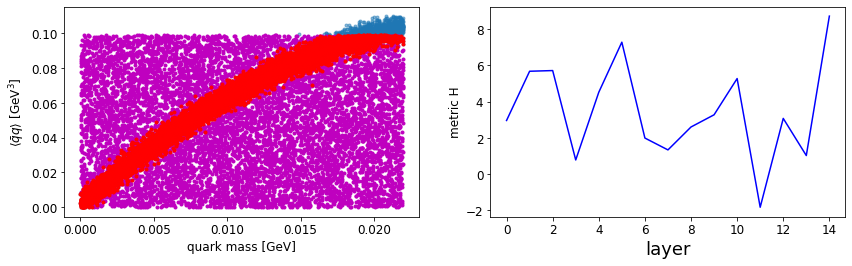

training epoch: 0,   loss: 0.2930491864681244
lambda: 0.18473921716213226,   AdS radius: 0.8077868223190308[1/GeV]


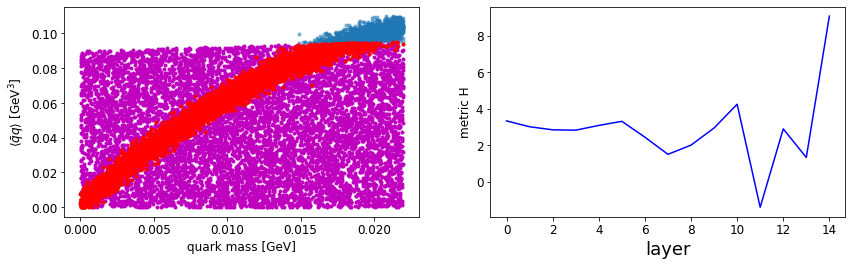

training epoch: 100,   loss: 0.24643979966640472
lambda: -2.0309040546417236,   AdS radius: 1.0685917139053345[1/GeV]


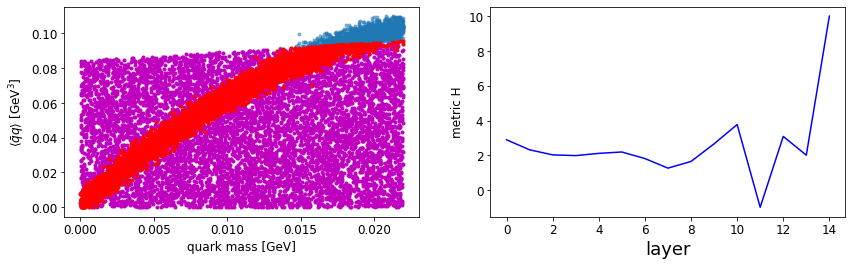

training epoch: 200,   loss: 0.2381560355424881
lambda: -4.231053352355957,   AdS radius: 1.397275447845459[1/GeV]


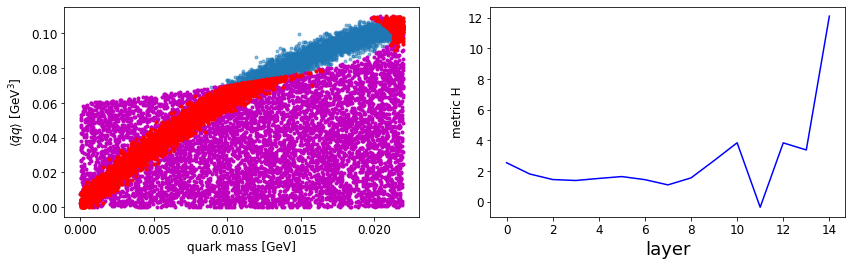

training epoch: 300,   loss: 0.21762488782405853
lambda: -4.968679904937744,   AdS radius: 1.8926936388015747[1/GeV]


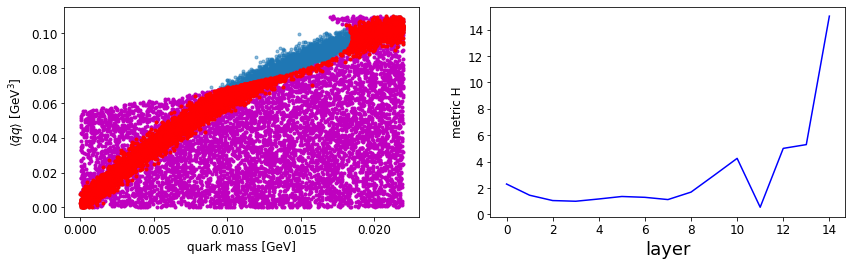

training epoch: 400,   loss: 0.20284824073314667
lambda: -4.292768955230713,   AdS radius: 1.92259681224823[1/GeV]


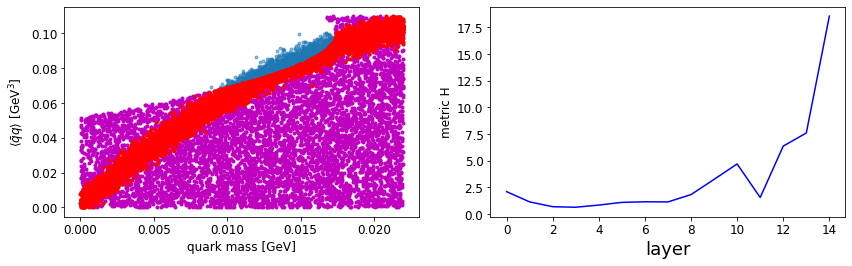

training epoch: 500,   loss: 0.18667596578598022
lambda: -3.355297803878784,   AdS radius: 1.9341801404953003[1/GeV]


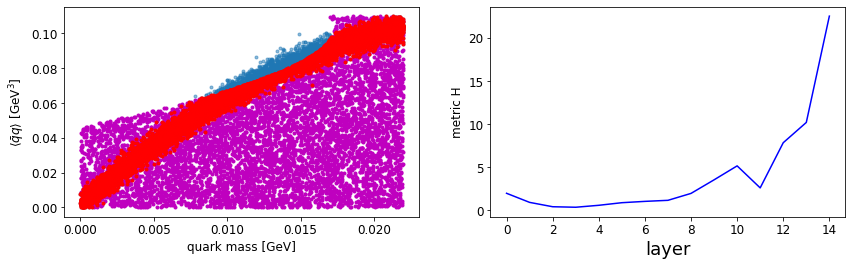

training epoch: 600,   loss: 0.1701582670211792
lambda: -2.1559855937957764,   AdS radius: 1.9858125448226929[1/GeV]


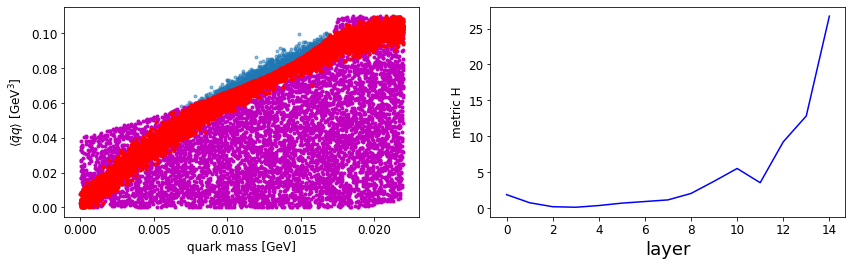

training epoch: 700,   loss: 0.1548834592103958
lambda: -0.6809512376785278,   AdS radius: 2.1917004585266113[1/GeV]


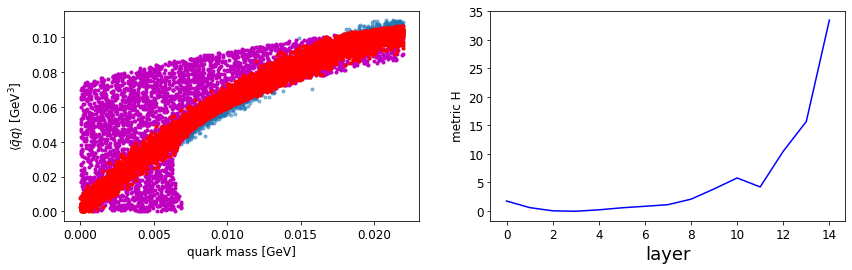

training epoch: 800,   loss: 0.05747246742248535
lambda: 0.008792617358267307,   AdS radius: 4.206849098205566[1/GeV]


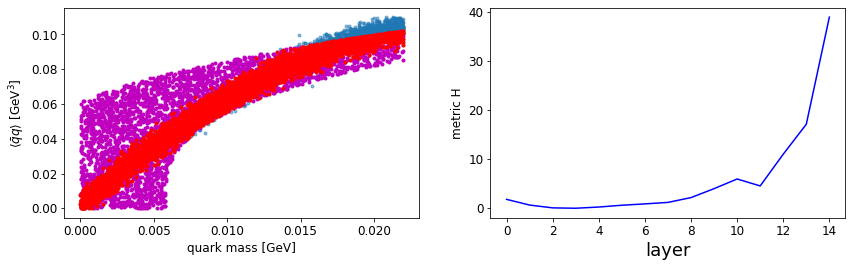

training epoch: 900,   loss: 0.04815564304590225
lambda: 0.007003243081271648,   AdS radius: 4.300310134887695[1/GeV]


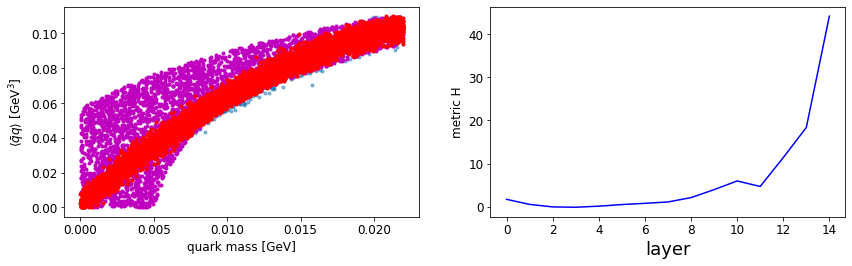

training epoch: 1000,   loss: 0.04131288453936577
lambda: 0.0046353708021342754,   AdS radius: 4.268406391143799[1/GeV]


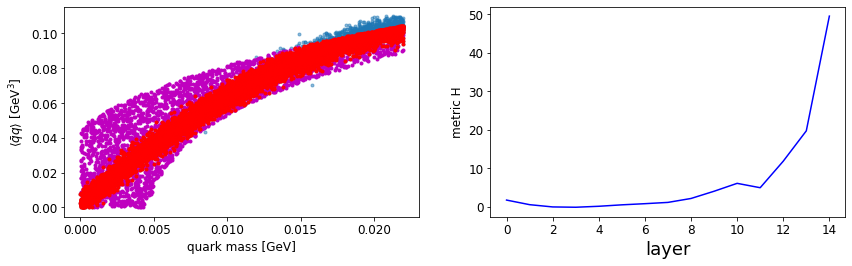

training epoch: 1100,   loss: 0.035942330956459045
lambda: 0.0055503761395812035,   AdS radius: 4.218236923217773[1/GeV]


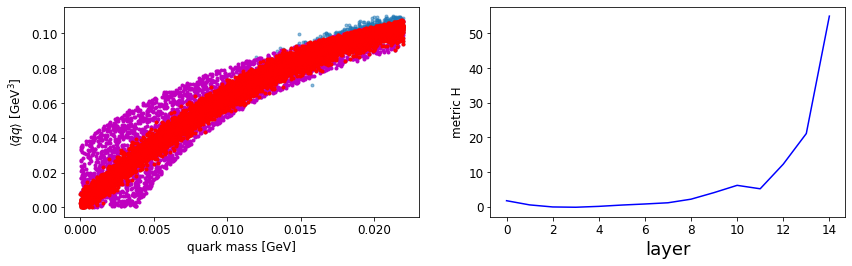

training epoch: 1200,   loss: 0.037173058837652206
lambda: 0.004848157055675983,   AdS radius: 4.13200044631958[1/GeV]


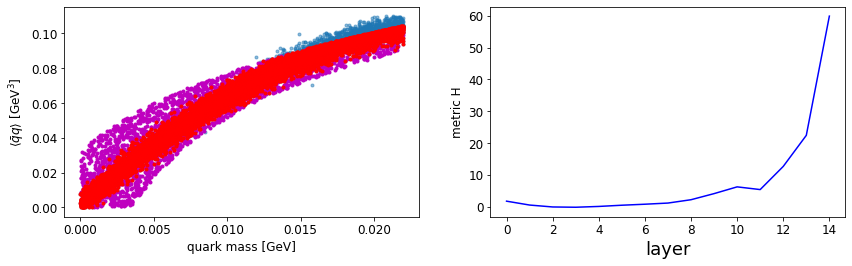

training epoch: 1300,   loss: 0.028864428400993347
lambda: 0.0059727695770561695,   AdS radius: 4.062776565551758[1/GeV]


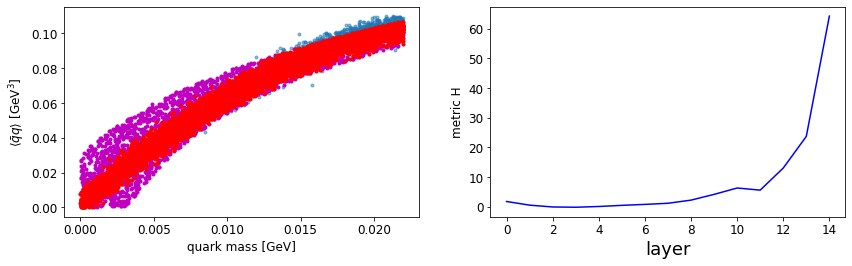

training epoch: 1400,   loss: 0.026196898892521858
lambda: 0.006503342185169458,   AdS radius: 3.9640250205993652[1/GeV]


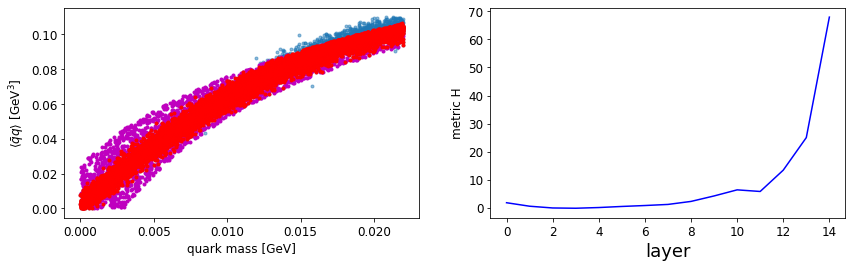

training epoch: 1500,   loss: 0.024608712643384933
lambda: 0.006878408137708902,   AdS radius: 3.884256362915039[1/GeV]


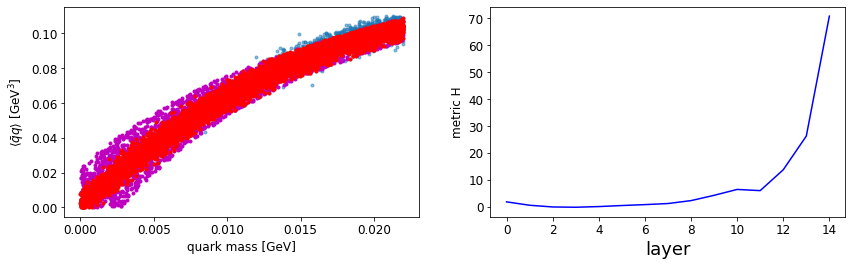

training epoch: 1600,   loss: 0.02389281429350376
lambda: 0.007110502105206251,   AdS radius: 3.7988126277923584[1/GeV]


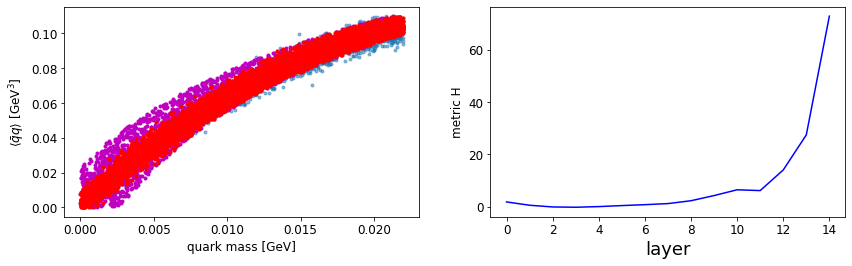

training epoch: 1700,   loss: 0.023253832012414932
lambda: 0.007809012662619352,   AdS radius: 3.7160823345184326[1/GeV]


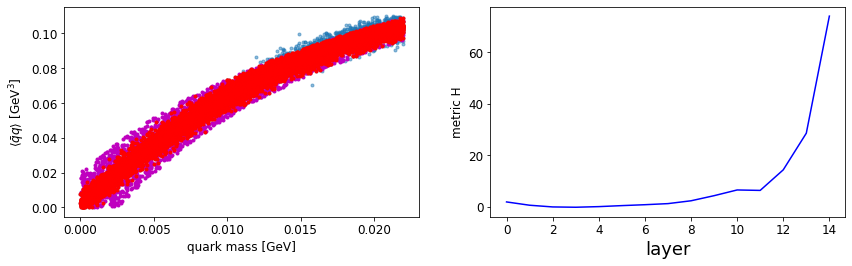

training epoch: 1800,   loss: 0.023868927732110023
lambda: 0.00909863505512476,   AdS radius: 3.6257574558258057[1/GeV]


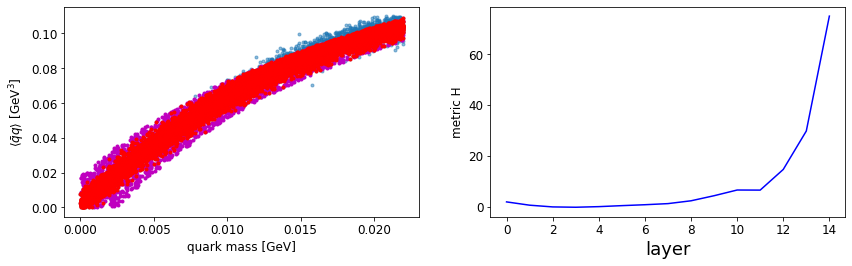

training epoch: 1900,   loss: 0.022387702018022537
lambda: 0.009754480794072151,   AdS radius: 3.573369264602661[1/GeV]


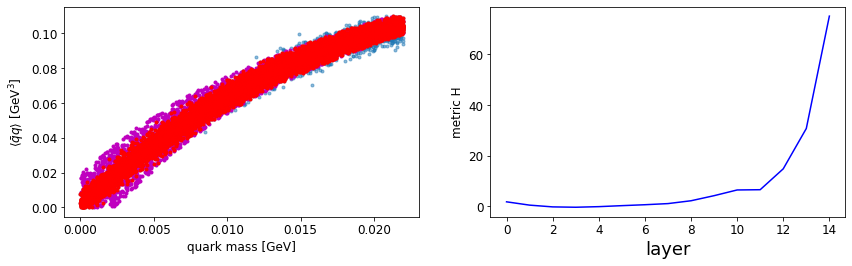

training epoch: 2000,   loss: 0.022037921473383904
lambda: 0.010603858157992363,   AdS radius: 3.5179927349090576[1/GeV]


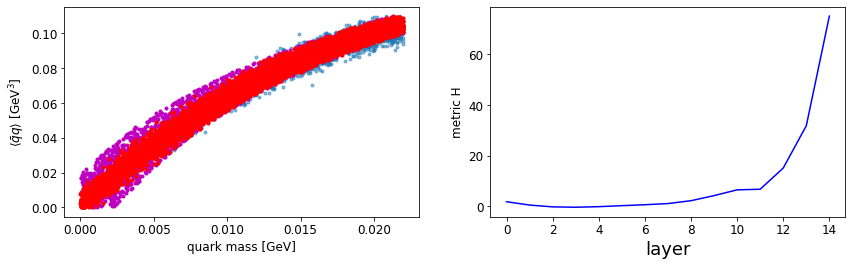

training epoch: 2100,   loss: 0.02133292518556118
lambda: 0.012285019271075726,   AdS radius: 3.4709694385528564[1/GeV]


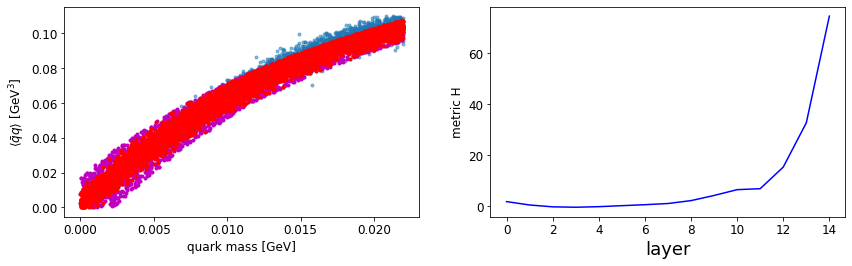

training epoch: 2200,   loss: 0.021239347755908966
lambda: 0.01362254936248064,   AdS radius: 3.4276487827301025[1/GeV]


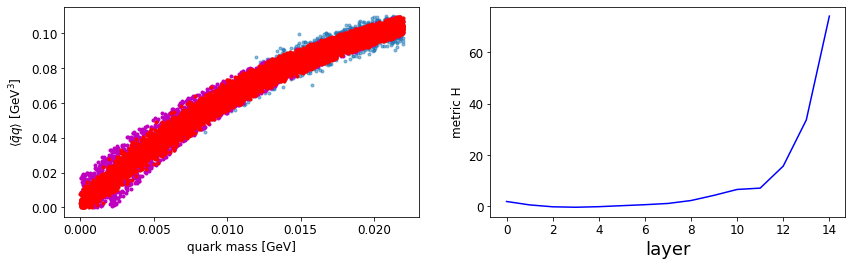

training epoch: 2300,   loss: 0.02106434293091297
lambda: 0.014383405447006226,   AdS radius: 3.39439058303833[1/GeV]


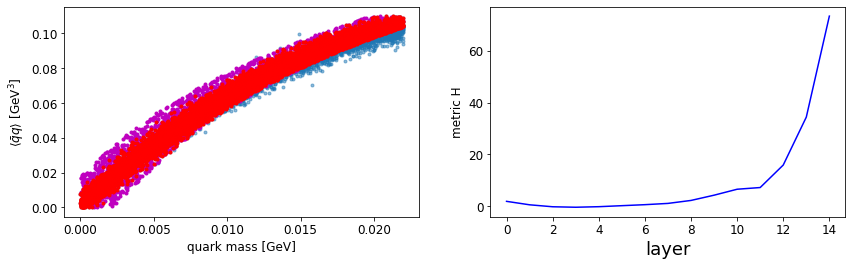

training epoch: 2400,   loss: 0.020091747865080833
lambda: 0.013271069154143333,   AdS radius: 3.363739490509033[1/GeV]


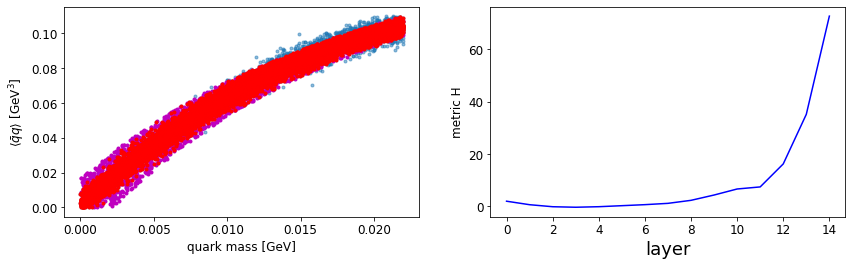

training epoch: 2500,   loss: 0.019848931580781937
lambda: 0.015546929091215134,   AdS radius: 3.3269903659820557[1/GeV]


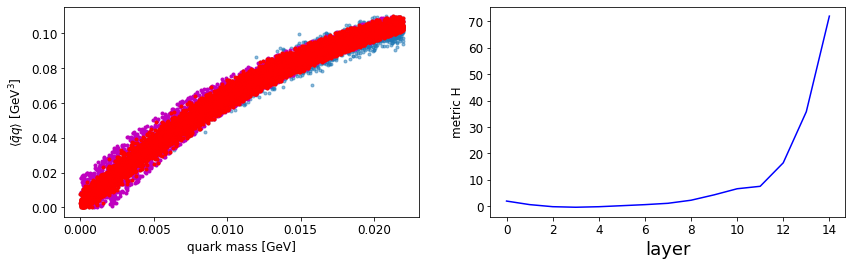

training epoch: 2600,   loss: 0.020234324038028717
lambda: 0.017141195014119148,   AdS radius: 3.2852816581726074[1/GeV]


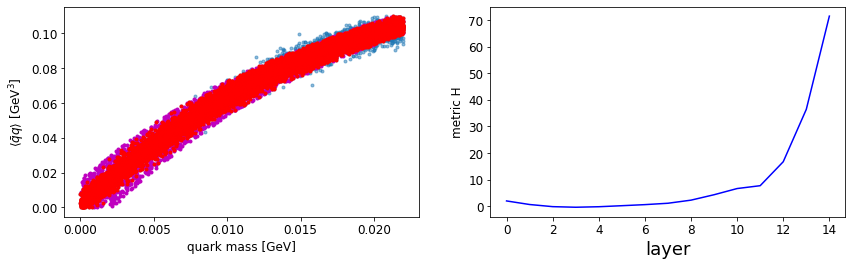

training epoch: 2700,   loss: 0.021056976169347763
lambda: 0.01686268113553524,   AdS radius: 3.250452995300293[1/GeV]


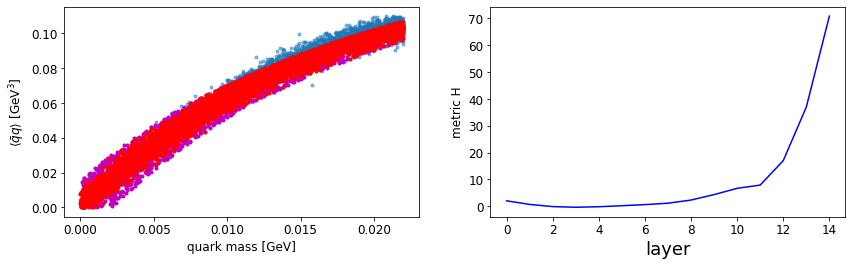

training epoch: 2800,   loss: 0.01985330693423748
lambda: 0.021166620776057243,   AdS radius: 3.228778839111328[1/GeV]


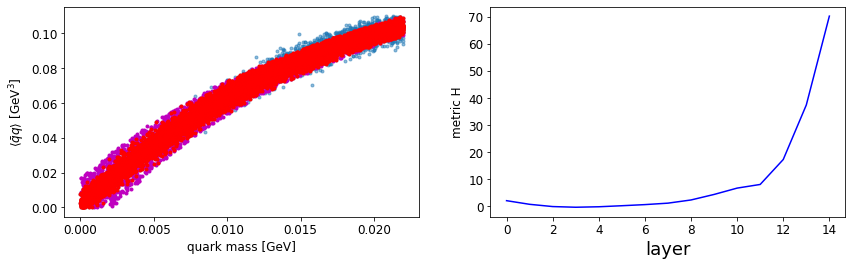

training epoch: 2900,   loss: 0.019692109897732735
lambda: 0.02238224633038044,   AdS radius: 3.186953544616699[1/GeV]


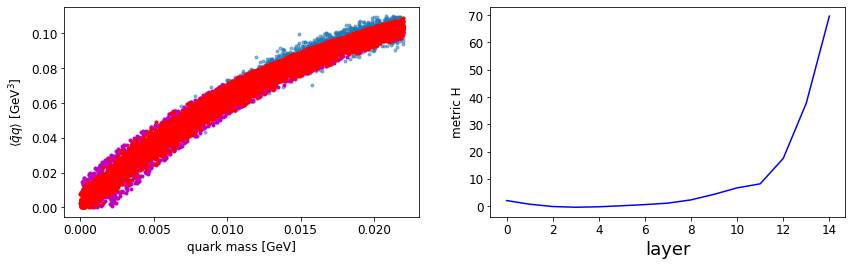

training epoch: 3000,   loss: 0.019179360941052437
lambda: 0.02347237803041935,   AdS radius: 3.169787883758545[1/GeV]


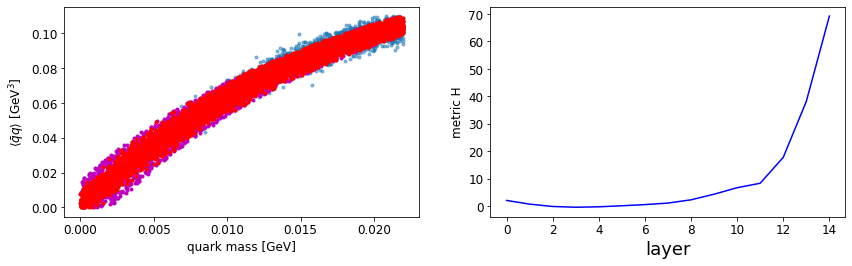

training epoch: 3100,   loss: 0.01903918944299221
lambda: 0.022307876497507095,   AdS radius: 3.1501262187957764[1/GeV]


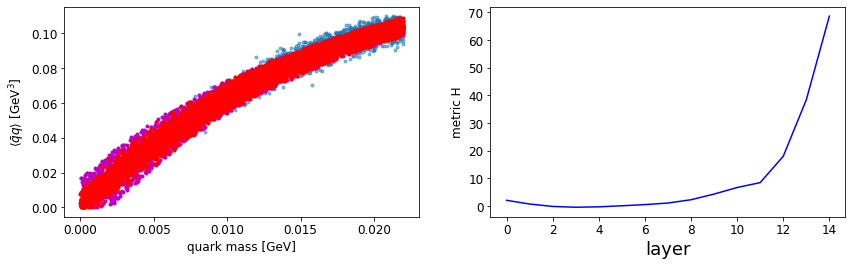

training epoch: 3200,   loss: 0.019649818539619446
lambda: 0.026920057833194733,   AdS radius: 3.1260409355163574[1/GeV]


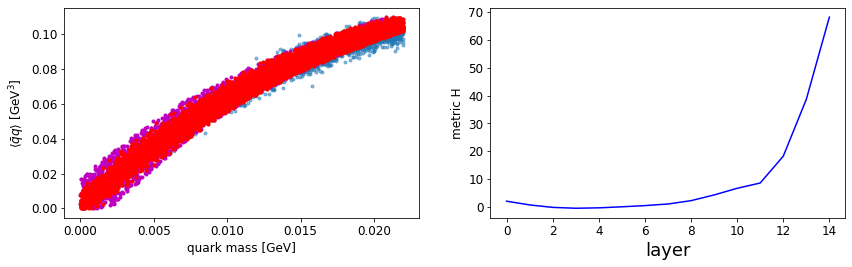

training epoch: 3300,   loss: 0.019775204360485077
lambda: 0.02514868974685669,   AdS radius: 3.1026973724365234[1/GeV]


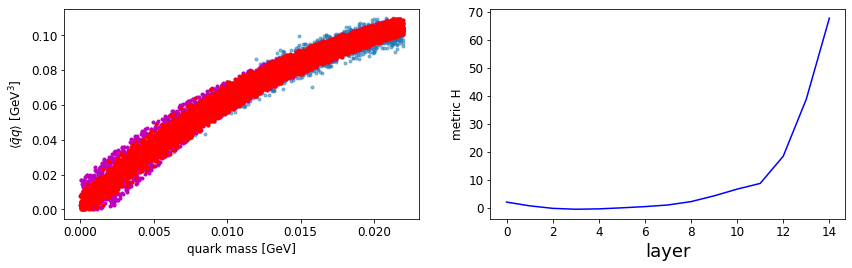

training epoch: 3400,   loss: 0.019399572163820267
lambda: 0.02825034409761429,   AdS radius: 3.0881507396698[1/GeV]


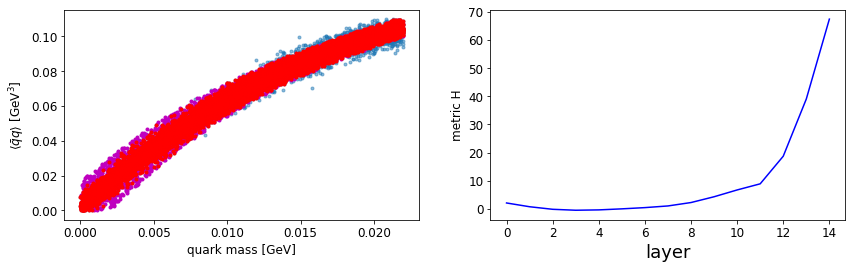

training epoch: 3500,   loss: 0.019033288583159447
lambda: 0.02857588604092598,   AdS radius: 3.0725369453430176[1/GeV]


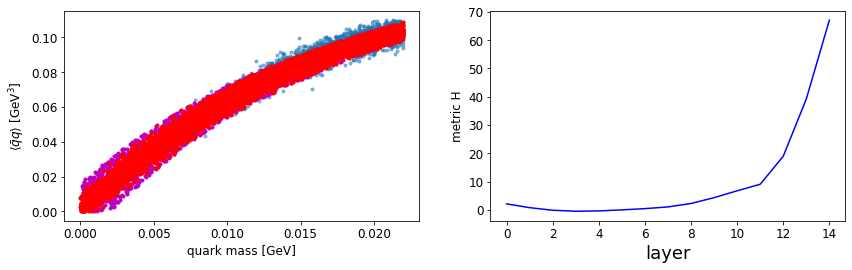

training epoch: 3600,   loss: 0.01839355193078518
lambda: 0.03146783635020256,   AdS radius: 3.0593199729919434[1/GeV]


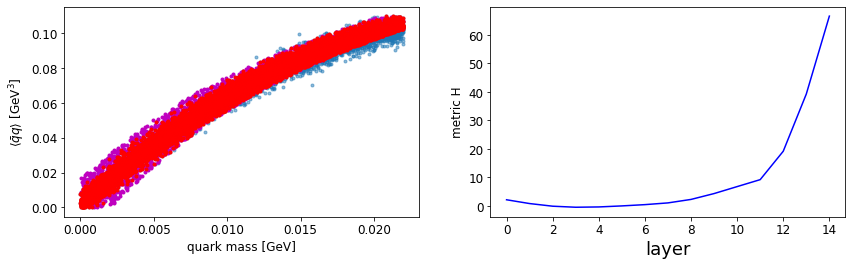

training epoch: 3700,   loss: 0.01946166530251503
lambda: 0.02852536365389824,   AdS radius: 3.040468692779541[1/GeV]


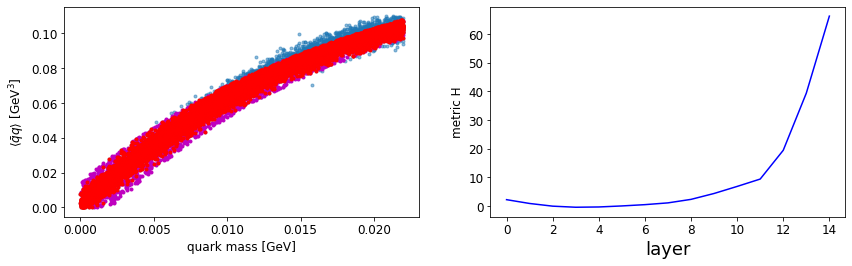

training epoch: 3800,   loss: 0.018402591347694397
lambda: 0.0309146735817194,   AdS radius: 3.034510374069214[1/GeV]


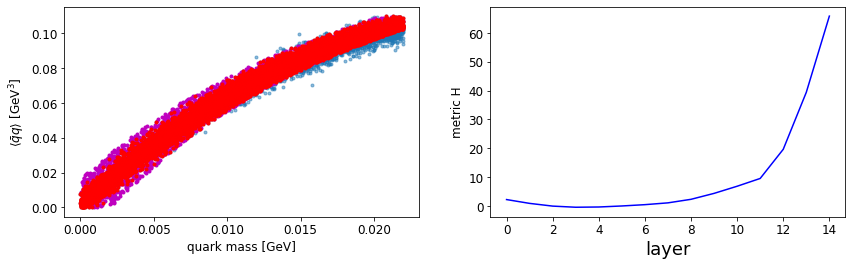

training epoch: 3900,   loss: 0.01870770938694477
lambda: 0.029844993725419044,   AdS radius: 3.0118935108184814[1/GeV]


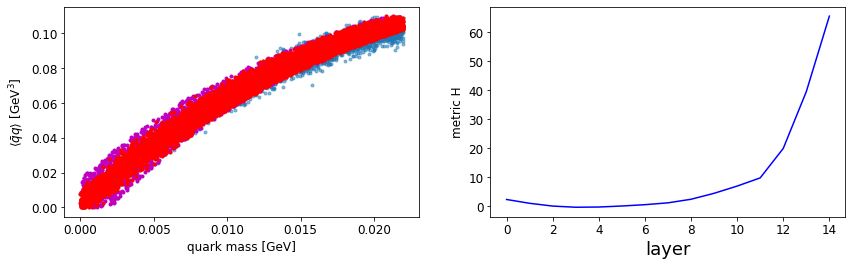

training epoch: 4000,   loss: 0.01804870367050171
lambda: 0.03254680708050728,   AdS radius: 2.994119882583618[1/GeV]


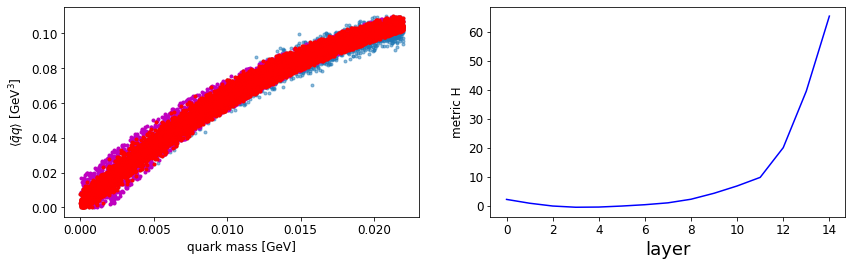

training epoch: 4100,   loss: 0.01826499029994011
lambda: 0.035232994705438614,   AdS radius: 2.9859228134155273[1/GeV]


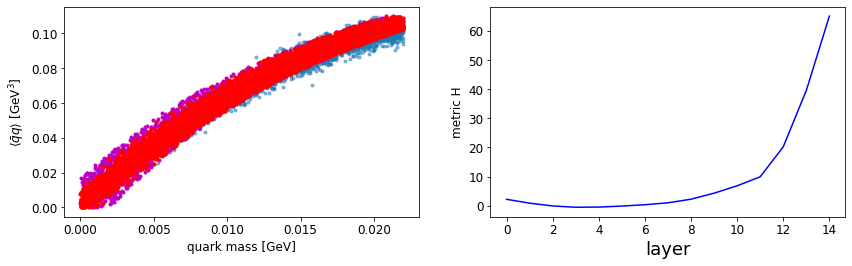

training epoch: 4200,   loss: 0.017771093174815178
lambda: 0.03479195013642311,   AdS radius: 2.9762277603149414[1/GeV]


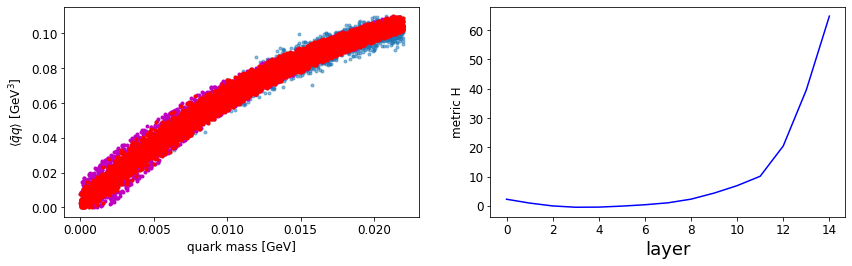

training epoch: 4300,   loss: 0.017865817993879318
lambda: 0.03562958538532257,   AdS radius: 2.9719455242156982[1/GeV]


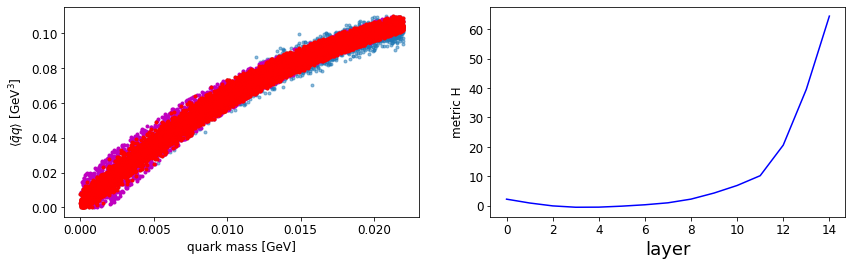

training epoch: 4400,   loss: 0.017837028950452805
lambda: 0.037501078099012375,   AdS radius: 2.9581851959228516[1/GeV]


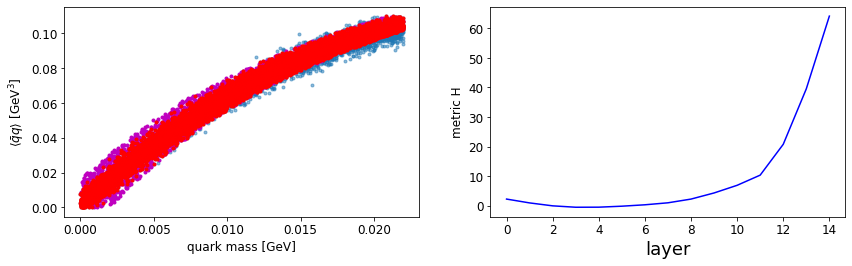

training epoch: 4500,   loss: 0.017746496945619583
lambda: 0.03757283091545105,   AdS radius: 2.946221113204956[1/GeV]


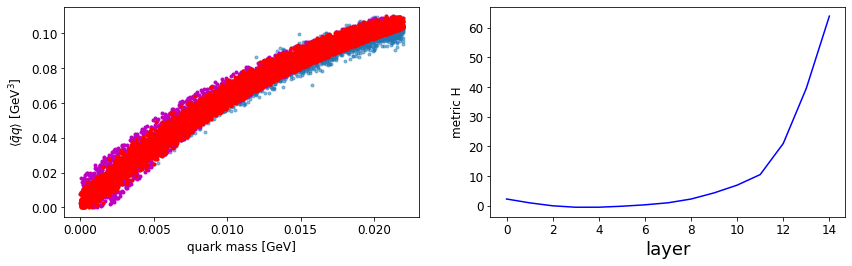

training epoch: 4600,   loss: 0.018036989495158195
lambda: 0.03834041580557823,   AdS radius: 2.9320971965789795[1/GeV]


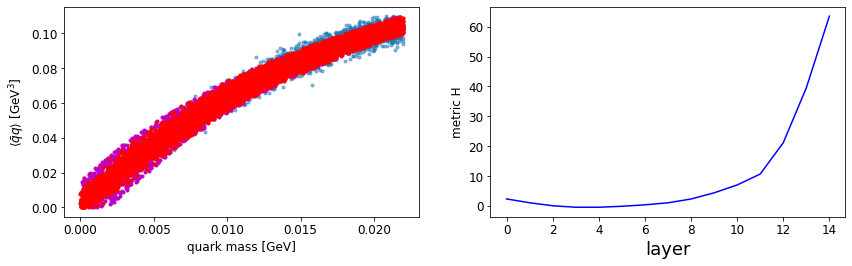

training epoch: 4700,   loss: 0.01791684329509735
lambda: 0.04163599759340286,   AdS radius: 2.923539161682129[1/GeV]


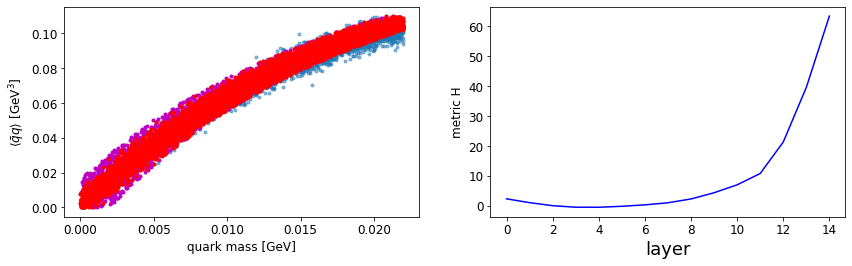

training epoch: 4800,   loss: 0.017648473381996155
lambda: 0.03981978818774223,   AdS radius: 2.9105966091156006[1/GeV]


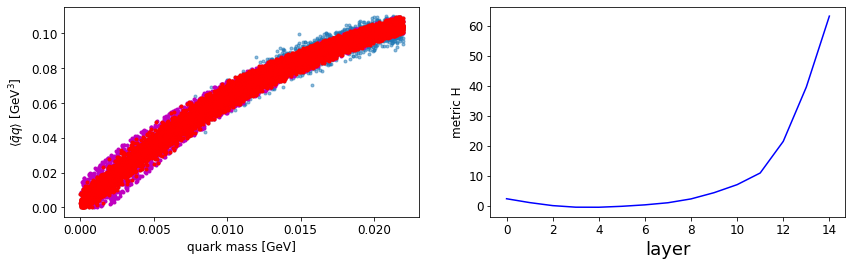

training epoch: 4900,   loss: 0.0178112480789423
lambda: 0.04332757368683815,   AdS radius: 2.8979671001434326[1/GeV]


In [9]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
    

In [10]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]
print(np.array(a))

[ 2.3297291e+00  1.0528286e+00  3.8636405e-02 -4.9562049e-01
 -5.2601033e-01 -2.1651532e-01  2.6794261e-01  9.7697699e-01
  2.2589989e+00  4.3379722e+00  7.0342908e+00  1.1025366e+01
  2.1576565e+01  3.9509514e+01  6.2988686e+01]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [0]:
%%bash
mkdir trained_models

mkdir: trained_models: File exists


Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [0]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [0]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [0]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

array([[ 3.85264516]], dtype=float32)

In [0]:
model.lamb.weight.data.numpy() # lambda

array([[ 0.00545012]], dtype=float32)

In [0]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)

[[ 3.13351607]]
[[ 2.39271212]]
[[ 1.60696924]]
[[ 0.8100372]]
[[ 0.06195514]]
[[-0.5439406]]
[[-0.87814671]]
[[-0.77317631]]
[[-0.00735563]]
[[ 1.74285817]]
[[ 4.97534227]]
[[ 10.37840176]]
[[ 18.70586967]]
[[ 30.80181313]]
[[ 46.99329758]]
